<a href="https://colab.research.google.com/github/archietech-ai/QKV/blob/main/Casual_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# Chapter 3: Coding Attention Mechanisms

Packages that are being used in this notebook:

In [2]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.5.1+cu121


- This chapter covers attention mechanisms, the engine of LLMs:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/01.webp?123" width="500px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/02.webp" width="600px">

## 3.1 The problem with modeling long sequences

- No code in this section
- Translating a text word by word isn't feasible due to the differences in grammatical structures between the source and target languages:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/03.webp" width="400px">

- Prior to the introduction of transformer models, encoder-decoder RNNs were commonly used for machine translation tasks
- In this setup, the encoder processes a sequence of tokens from the source language, using a hidden state—a kind of intermediate layer within the neural network—to generate a condensed representation of the entire input sequence:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/04.webp" width="500px">

## 3.2 Capturing data dependencies with attention mechanisms

- No code in this section
- Through an attention mechanism, the text-generating decoder segment of the network is capable of selectively accessing all input tokens, implying that certain input tokens hold more significance than others in the generation of a specific output token:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/05.webp" width="500px">

- Self-attention in transformers is a technique designed to enhance input representations by enabling each position in a sequence to engage with and determine the relevance of every other position within the same sequence

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/06.webp" width="300px">

## 3.3 Attending to different parts of the input with self-attention

### 3.3.1 A simple self-attention mechanism without trainable weights

- This section explains a very simplified variant of self-attention, which does not contain any trainable weights
- This is purely for illustration purposes and NOT the attention mechanism that is used in transformers
- The next section, section 3.3.2, will extend this simple attention mechanism to implement the real self-attention mechanism
- Suppose we are given an input sequence $x^{(1)}$ to $x^{(T)}$
  - The input is a text (for example, a sentence like "Your journey starts with one step") that has already been converted into token embeddings as described in chapter 2
  - For instance, $x^{(1)}$ is a d-dimensional vector representing the word "Your", and so forth
- **Goal:** compute context vectors $z^{(i)}$ for each input sequence element $x^{(i)}$ in $x^{(1)}$ to $x^{(T)}$ (where $z$ and $x$ have the same dimension)
    - A context vector $z^{(i)}$ is a weighted sum over the inputs $x^{(1)}$ to $x^{(T)}$
    - The context vector is "context"-specific to a certain input
      - Instead of $x^{(i)}$ as a placeholder for an arbitrary input token, let's consider the second input, $x^{(2)}$
      - And to continue with a concrete example, instead of the placeholder $z^{(i)}$, we consider the second output context vector, $z^{(2)}$
      - The second context vector, $z^{(2)}$, is a weighted sum over all inputs $x^{(1)}$ to $x^{(T)}$ weighted with respect to the second input element, $x^{(2)}$
      - The attention weights are the weights that determine how much each of the input elements contributes to the weighted sum when computing $z^{(2)}$
      - In short, think of $z^{(2)}$ as a modified version of $x^{(2)}$ that also incorporates information about all other input elements that are relevant to a given task at hand

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/07.webp" width="400px">

- (Please note that the numbers in this figure are truncated to one
digit after the decimal point to reduce visual clutter; similarly, other figures may also contain truncated values)

- By convention, the unnormalized attention weights are referred to as **"attention scores"** whereas the normalized attention scores, which sum to 1, are referred to as **"attention weights"**


- The code below walks through the figure above step by step

<br>

- **Step 1:** compute unnormalized attention scores $\omega$
- Suppose we use the second input token as the query, that is, $q^{(2)} = x^{(2)}$, we compute the unnormalized attention scores via dot products:
    - $\omega_{21} = x^{(1)} q^{(2)\top}$
    - $\omega_{22} = x^{(2)} q^{(2)\top}$
    - $\omega_{23} = x^{(3)} q^{(2)\top}$
    - ...
    - $\omega_{2T} = x^{(T)} q^{(2)\top}$
- Above, $\omega$ is the Greek letter "omega" used to symbolize the unnormalized attention scores
    - The subscript "21" in $\omega_{21}$ means that input sequence element 2 was used as a query against input sequence element 1

- Suppose we have the following input sentence that is already embedded in 3-dimensional vectors as described in chapter 3 (we use a very small embedding dimension here for illustration purposes, so that it fits onto the page without line breaks):

In [3]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

- (In this book, we follow the common machine learning and deep learning convention where training examples are represented as rows and feature values as columns; in the case of the tensor shown above, each row represents a word, and each column represents an embedding dimension)

- The primary objective of this section is to demonstrate how the context vector $z^{(2)}$
  is calculated using the second input sequence, $x^{(2)}$, as a query

- The figure depicts the initial step in this process, which involves calculating the attention scores ω between $x^{(2)}$
  and all other input elements through a dot product operation

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/08.webp" width="400px">

- We use input sequence element 2, $x^{(2)}$, as an example to compute context vector $z^{(2)}$; later in this section, we will generalize this to compute all context vectors.
- The first step is to compute the unnormalized attention scores by computing the dot product between the query $x^{(2)}$ and all other input tokens:

In [4]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0]) # gets the size of the first dimension of the inputs tensor. If inputs has shape [4, 8] (4 rows, 8 columns) then inputs.shape[0] would be 4
# For example torch.empty(4) would then create a 1D tensor of size 4
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # Computes dot product between each input vector and the query. dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


- Side note: a dot product is essentially a shorthand for multiplying two vectors elements-wise and summing the resulting products:

In [5]:
res = 0.

for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]

print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


- **Step 2:** normalize the unnormalized attention scores ("omegas", $\omega$) so that they sum up to 1
- Here is a simple way to normalize the unnormalized attention scores to sum up to 1 (a convention, useful for interpretation, and important for training stability):

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/09.webp" width="500px">

In [6]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


- However, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.
- Here's a naive implementation of a softmax function for scaling, which also normalizes the vector elements such that they sum up to 1:

In [7]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


- The naive implementation above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues
- Hence, in practice, it's recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [8]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


- **Step 3**: compute the context vector $z^{(2)}$ by multiplying the embedded input tokens, $x^{(i)}$ with the attention weights and sum the resulting vectors:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/10.webp" width="500px">

In [9]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### 3.3.2 Computing attention weights for all input tokens

#### Generalize to all input sequence tokens:

- Above, we computed the attention weights and context vector for input 2 (as illustrated in the highlighted row in the figure below)
- Next, we are generalizing this computation to compute all attention weights and context vectors

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/11.webp" width="400px">

- (Please note that the numbers in this figure are truncated to two
digits after the decimal point to reduce visual clutter; the values in each row should add up to 1.0 or 100%; similarly, digits in other figures are truncated)

- In self-attention, the process starts with the calculation of attention scores, which are subsequently normalized to derive attention weights that total 1
- These attention weights are then utilized to generate the context vectors through a weighted summation of the inputs

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/12.webp" width="400px">

- Apply previous **step 1** to all pairwise elements to compute the unnormalized attention score matrix:

In [10]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


- We can achieve the same as above more efficiently via matrix multiplication:

In [11]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


- Similar to **step 2** previously, we normalize each row so that the values in each row sum to 1:

In [12]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


- Quick verification that the values in each row indeed sum to 1:

In [13]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)

print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


- Apply previous **step 3** to compute all context vectors:

In [14]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


- As a sanity check, the previously computed context vector $z^{(2)} = [0.4419, 0.6515, 0.5683]$ can be found in the 2nd row in above:

In [15]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


## 3.4 Implementing self-attention with trainable weights

- A conceptual framework illustrating how the self-attention mechanism developed in this section integrates into the overall narrative and structure of this book and chapter

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/13.webp" width="400px">

### 3.4.1 Computing the attention weights step by step

- In this section, we are implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other popular LLMs
- This self-attention mechanism is also called "scaled dot-product attention"
- The overall idea is similar to before:
  - We want to compute context vectors as weighted sums over the input vectors specific to a certain input element
  - For the above, we need attention weights
- As you will see, there are only slight differences compared to the basic attention mechanism introduced earlier:
  - The most notable difference is the introduction of weight matrices that are updated during model training
  - These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce "good" context vectors

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/14.webp" width="600px">

- Implementing the self-attention mechanism step by step, we will start by introducing the three training weight matrices $W_q$, $W_k$, and $W_v$
- These three matrices are used to project the embedded input tokens, $x^{(i)}$, into query, key, and value vectors via matrix multiplication:

  - Query vector: $q^{(i)} = W_q \,x^{(i)}$
  - Key vector: $k^{(i)} = W_k \,x^{(i)}$
  - Value vector: $v^{(i)} = W_v \,x^{(i)}$


- The embedding dimensions of the input $x$ and the query vector $q$ can be the same or different, depending on the model's design and specific implementation
- In GPT models, the input and output dimensions are usually the same, but for illustration purposes, to better follow the computation, we choose different input and output dimensions here:

In [16]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

- Below, we initialize the three weight matrices; note that we are setting `requires_grad=False` to reduce clutter in the outputs for illustration purposes, but if we were to use the weight matrices for model training, we would set `requires_grad=True` to update these matrices during model training

In [17]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

- Next we compute the query, key, and value vectors:

In [18]:
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


- As we can see below, we successfully projected the 6 input tokens from a 3D onto a 2D embedding space:

In [19]:
keys = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


- In the next step, **step 2**, we compute the unnormalized attention scores by computing the dot product between the query and each key vector:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/15.webp" width="600px">

In [20]:
keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


- Since we have 6 inputs, we have 6 attention scores for the given query vector:

In [21]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/16.webp" width="600px">

- Next, in **step 3**, we compute the attention weights (normalized attention scores that sum up to 1) using the softmax function we used earlier
- The difference to earlier is that we now scale the attention scores by dividing them by the square root of the embedding dimension, $\sqrt{d_k}$ (i.e., `d_k**0.5`):

In [22]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/17.webp" width="600px">

- In **step 4**, we now compute the context vector for input query vector 2:

In [23]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


### 3.4.2 Implementing a compact SelfAttention class

- Putting it all together, we can implement the self-attention mechanism as follows:

In [24]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/18.webp" width="400px">

- We can streamline the implementation above using PyTorch's Linear layers, which are equivalent to a matrix multiplication if we disable the bias units
- Another big advantage of using `nn.Linear` over our manual `nn.Parameter(torch.rand(...)` approach is that `nn.Linear` has a preferred weight initialization scheme, which leads to more stable model training

In [25]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


- Note that `SelfAttention_v1` and `SelfAttention_v2` give different outputs because they use different initial weights for the weight matrices

## 3.5 Hiding future words with causal attention

- In causal attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/19.webp" width="400px">

### 3.5.1 Applying a causal attention mask

- In this section, we are converting the previous self-attention mechanism into a causal self-attention mechanism
- Causal self-attention ensures that the model's prediction for a certain position in a sequence is only dependent on the known outputs at previous positions, not on future positions
- In simpler words, this ensures that each next word prediction should only depend on the preceding words
- To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text):

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/20.webp" width="600px">

- To illustrate and implement causal self-attention, let's work with the attention scores and weights from the previous section:

In [26]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


- The simplest way to mask out future attention weights is by creating a mask via PyTorch's tril function with elements below the main diagonal (including the diagonal itself) set to 1 and above the main diagonal set to 0:

In [27]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


- Then, we can multiply the attention weights with this mask to zero out the attention scores above the diagonal:

In [28]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


- However, if the mask were applied after softmax, like above, it would disrupt the probability distribution created by softmax
- Softmax ensures that all output values sum to 1
- Masking after softmax would require re-normalizing the outputs to sum to 1 again, which complicates the process and might lead to unintended effects

- To make sure that the rows sum to 1, we can normalize the attention weights as follows:

In [29]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


- While we are technically done with coding the causal attention mechanism now, let's briefly look at a more efficient approach to achieve the same as above
- So, instead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/21.webp" width="450px">

In [30]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


- As we can see below, now the attention weights in each row correctly sum to 1 again:

In [31]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### 3.5.2 Masking additional attention weights with dropout

- In addition, we also apply dropout to reduce overfitting during training
- Dropout can be applied in several places:
  - for example, after computing the attention weights;
  - or after multiplying the attention weights with the value vectors
- Here, we will apply the dropout mask after computing the attention weights because it's more common

- Furthermore, in this specific example, we use a dropout rate of 50%, which means randomly masking out half of the attention weights. (When we train the GPT model later, we will use a lower dropout rate, such as 0.1 or 0.2

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/22.webp" width="400px">

- If we apply a dropout rate of 0.5 (50%), the non-dropped values will be scaled accordingly by a factor of 1/0.5 = 2
- The scaling is calculated by the formula 1 / (1 - `dropout_rate`)

In [32]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [33]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


- Note that the resulting dropout outputs may look different depending on your operating system; you can read more about this inconsistency [here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)

### 3.5.3 Implementing a compact causal self-attention class

- Now, we are ready to implement a working implementation of self-attention, including the causal and dropout masks
- One more thing is to implement the code to handle batches consisting of more than one input so that our `CausalAttention` class supports the batch outputs produced by the data loader we implemented in chapter 2
- For simplicity, to simulate such batch input, we duplicate the input text example:

In [34]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


In [35]:
class CausalAttention(nn.Module): # Defines a new neural network module for causal attention (where each position can only attend to previous positions). Tis is teachnically is a head

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False): # Constructor taking input dimension, output dimension, context length, dropout rate, and optional bias flag for Q/K/V transformations
        super().__init__()
        self.d_out = d_out # Stores output dimension
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias) # Creates three linear transformations (this line and next two lines) for Query, Key, and Value vectors
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias) # Each (this line, previous and next line) transforms from d_in to d_out dimensions with optional bias
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New (Creates dropout layer for regularization)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New (Creates an upper triangular mask to prevent attending to future tokens)
        # register_buffer stores the mask in the model but doesn't treat it as a parameter
        # The "mask" is constant (just blocks future positions

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x) # Transforms input into Keys, Queries, and Values using the linear layers
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # See the following figure. We transpose dimention 1 and 2, keeping the batch dimension at the first position (0):
        attn_scores.masked_fill_(  # Applies causal mask by setting future positions to negative infinity
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


We transpose dimention 1 and 2, keeping the batch dimension at the first position (0). The second figure, where we show Matrix Multiplication, we show the dimentions not the real value.

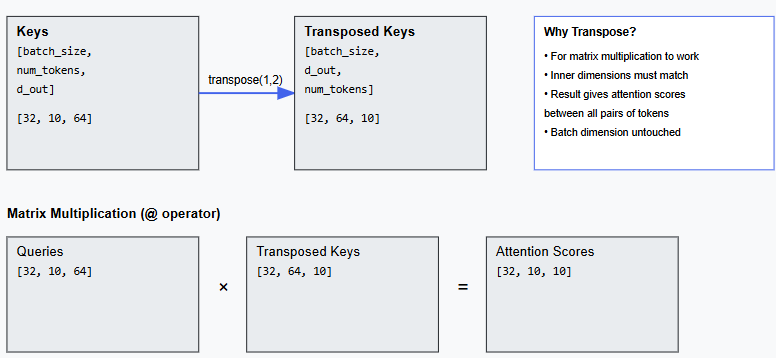

To show real value example for Matrix multiplication see the following figure:

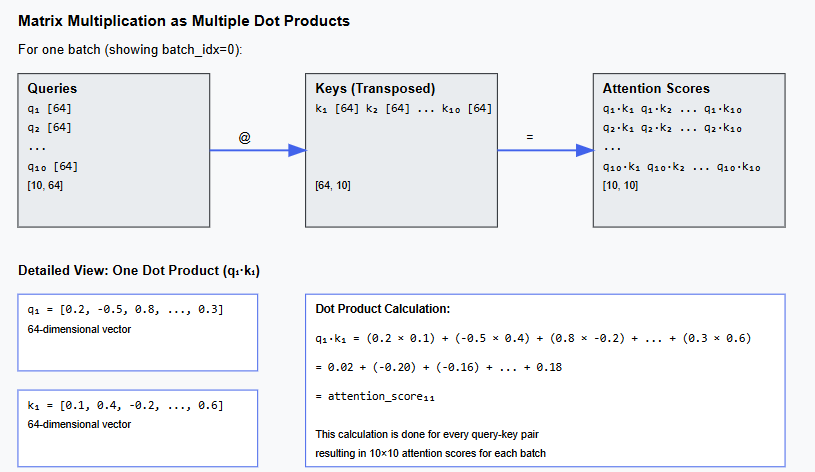

- Note that dropout is only applied during training, not during inference

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/23.webp" width="500px">

## 3.6 Extending single-head attention to multi-head attention

### 3.6.1 Stacking multiple single-head attention layers

- Below is a summary of the self-attention implemented previously (causal and dropout masks not shown for simplicity)

- This is also called single-head attention:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/24.webp" width="400px">

- We simply stack multiple single-head attention modules to obtain a multi-head attention module:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/25.webp" width="400px">

- The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections. This allows the model to jointly attend to information from different representation subspaces at different positions.

In [36]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


- In the implementation above, the embedding dimension is 4, because we `d_out=2` as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4

### 3.6.2 Implementing multi-head attention with weight splits

- While the above is an intuitive and fully functional implementation of multi-head attention (wrapping the single-head attention `CausalAttention` implementation from earlier), we can write a stand-alone class called `MultiHeadAttention` to achieve the same

- We don't concatenate single attention heads for this stand-alone `MultiHeadAttention` class
- Instead, we create single W_query, W_key, and W_value weight matrices and then split those into individual matrices for each attention head:

In [37]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- Note that the above is essentially a rewritten version of `MultiHeadAttentionWrapper` that is more efficient
- The resulting output looks a bit different since the random weight initializations differ, but both are fully functional implementations that can be used in the GPT class we will implement in the upcoming chapters
- Note that in addition, we added a linear projection layer (`self.out_proj `) to the `MultiHeadAttention` class above. This is simply a linear transformation that doesn't change the dimensions. It's a standard convention to use such a projection layer in LLM implementation, but it's not strictly necessary (recent research has shown that it can be removed without affecting the modeling performance; see the further reading section at the end of this chapter)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/26.webp" width="400px">

- Note that if you are interested in a compact and efficient implementation of the above, you can also consider the [`torch.nn.MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) class in PyTorch

- Since the above implementation may look a bit complex at first glance, let's look at what happens when executing `attn_scores = queries @ keys.transpose(2, 3)`:

In [38]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


- In this case, the matrix multiplication implementation in PyTorch will handle the 4-dimensional input tensor so that the matrix multiplication is carried out between the 2 last dimensions (num_tokens, head_dim) and then repeated for the individual heads

- For instance, the following becomes a more compact way to compute the matrix multiplication for each head separately:

In [39]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


# Summary and takeaways

- See the [./multihead-attention.ipynb](./multihead-attention.ipynb) code notebook, which is a concise version of the data loader (chapter 2) plus the multi-head attention class that we implemented in this chapter and will need for training the GPT model in upcoming chapters
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)